In [1]:
import sys
import os
sys.path.append(os.path.abspath('../..')) # include top level package in python path

In [2]:
import torch
from comparison.examples.vae_mnist import VAE_MNIST
from comparison.loss import ELBO_loss, IWAE_loss, var_log_evidence
from comparison.metric import sample_ess, norm_over
from tqdm.notebook import tqdm



In [3]:
# Change device as needed. 
# CPU is supported on all machines, CUDA for specific GPUs.

# device = 'cpu'
device = 'cuda'

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST('./_mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

test_dataset = datasets.MNIST('./_mnist', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [22]:
def train(model, optim, dataloader, no_epochs=3, K=8, M=8, neg_loss_fn = ELBO_loss):
    model.train()
    
    train_loss = []
    for epoch in range(1, no_epochs + 1):
        for imgs, _ in tqdm(dataloader, desc="Training Epoch №%s" % epoch, leave=False):
            imgs = imgs.view(-1, 28*28).to(device)
            vae_res = model(imgs, K=K, M=M)
            loss = -neg_loss_fn(vae_res)
            train_loss.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

    return torch.Tensor(train_loss)

In [6]:
model = VAE_MNIST().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
losses = train(model, optim, train_loader, 5)

Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №3:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №4:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №5:   0%|          | 0/469 [00:00<?, ?it/s]

In [9]:
from comparison.plot import plot_smoothed

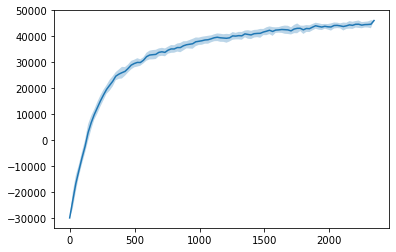

In [11]:
plot_smoothed(-losses, sigma=10, fit_sigma=True)

In [23]:
def compute_ess(model, T=100):
    effective_sample_sizes = []

    for imgs, _ in train_loader:
        with torch.no_grad():
            imgs = imgs.view(-1, 28*28).to(device)
            esss = sample_ess(model, imgs, T=100)

            for ess in list(esss):
                effective_sample_sizes.append(ess.item())
    return effective_sample_sizes

effective_sample_sizes = compute_ess(model)
    

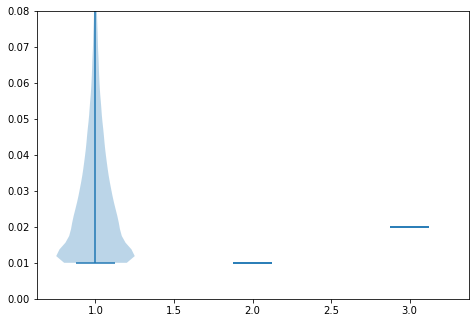

In [16]:
import matplotlib.pyplot as plt

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot([effective_sample_sizes, [1e-2], [2e-2]])
plt.ylim(0,8e-2)
plt.show()

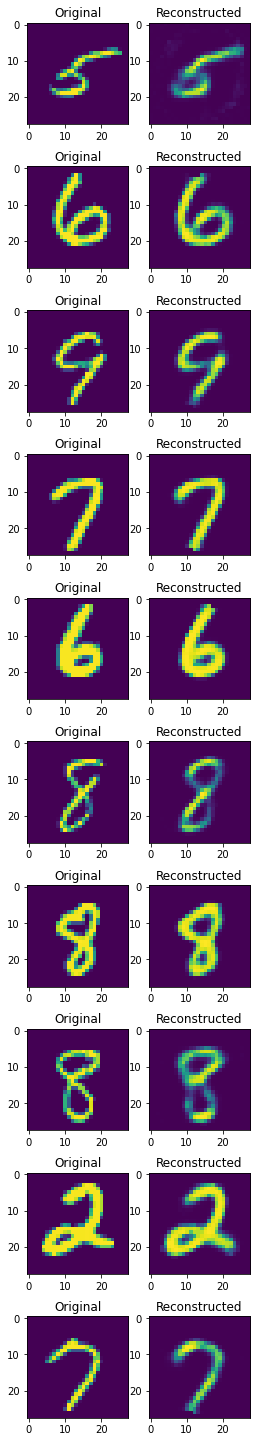

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,26))

for imgs, _ in test_loader:
    for i in range(imgs.shape[0]):
        if i >= 10:
            break
        img = imgs[i].view(28 * 28).to(device)
        recon = model.reconstruct(img)
        ax = plt.subplot(10, 2, 2 * i + 1)
        ax.imshow(img.view(28, 28).clone().detach().cpu())
        plt.title("Original")
        ax = plt.subplot(10, 2, 2 * i + 2)
        ax.imshow(recon.view(28, 28).clone().detach().cpu())
        plt.title("Reconstructed")
        
plt.show()